In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset paths and labels
def load_dataset(file_path):
    image_paths = []
    labels = []
    with open(file_path, 'r') as f:
        for line in f:
            # Strip the line to remove unnecessary spaces and split into components
            parts = line.strip().split()
            if len(parts) >= 2:  # Ensure there are at least two elements
                image_paths.append(parts[0])  # The first element is the image path
                labels.append(int(parts[1]))  # The second element is the label (converted to int)
    return image_paths, labels

# Specify the file path
data_file = "Ground_truth.lst"

# Load the dataset
try:
    image_paths, labels = load_dataset(data_file)
    print(f"Loaded {len(image_paths)} images and {len(labels)} labels.")
except FileNotFoundError:
    print(f"Error: The file '{data_file}' was not found.")
except ValueError as e:
    print(f"Error: {e}. Please check the file format.")


Loaded 96798 images and 96798 labels.


In [14]:
class CellCycleDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

from torchvision import transforms
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Converts to [C, H, W]
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Split data
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create datasets
train_dataset = CellCycleDataset(train_paths, train_labels, transform=transform)
test_dataset = CellCycleDataset(test_paths, test_labels, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [16]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            # First Convolutional Block
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Input channel = 1 for grayscale
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample by 2
            
            # Second Convolutional Block
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample by 2
            
            # Third Convolutional Block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample by 2
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),  # Adjust based on the input size and number of pooling layers
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3),  # Number of classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate and move to the appropriate device
cnn_model = CNNModel().to(device)
print(cnn_model)


CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=128, bias=True)
    (2): ReLU()
    (3): Drop

In [12]:
from torchvision import transforms
import torch

# Define data preprocessing pipeline
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((128, 128)),               # Resize images
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class TransformerModel(nn.Module):
    def __init__(self, img_size=128, patch_size=16, embed_dim=128, num_heads=4, ff_dim=256, num_classes=3):
        super(TransformerModel, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim

        # Linear layer for patch embedding
        self.embedding = nn.Linear(patch_size * patch_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim),
            num_layers=4
        )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Patchify images
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, -1, self.patch_size * self.patch_size)

        # Embed patches
        x = self.embedding(patches) + self.positional_encoding

        # Transformer encoder
        x = self.transformer(x)
        x = x.mean(dim=1)  # Aggregate features
        x = self.fc(x)  # Classification
        return x

transformer_model = TransformerModel(embed_dim=128, num_heads=4, ff_dim=256, num_classes=3).to(device)
print(transformer_model)

TransformerModel(
  (embedding): Linear(in_features=256, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


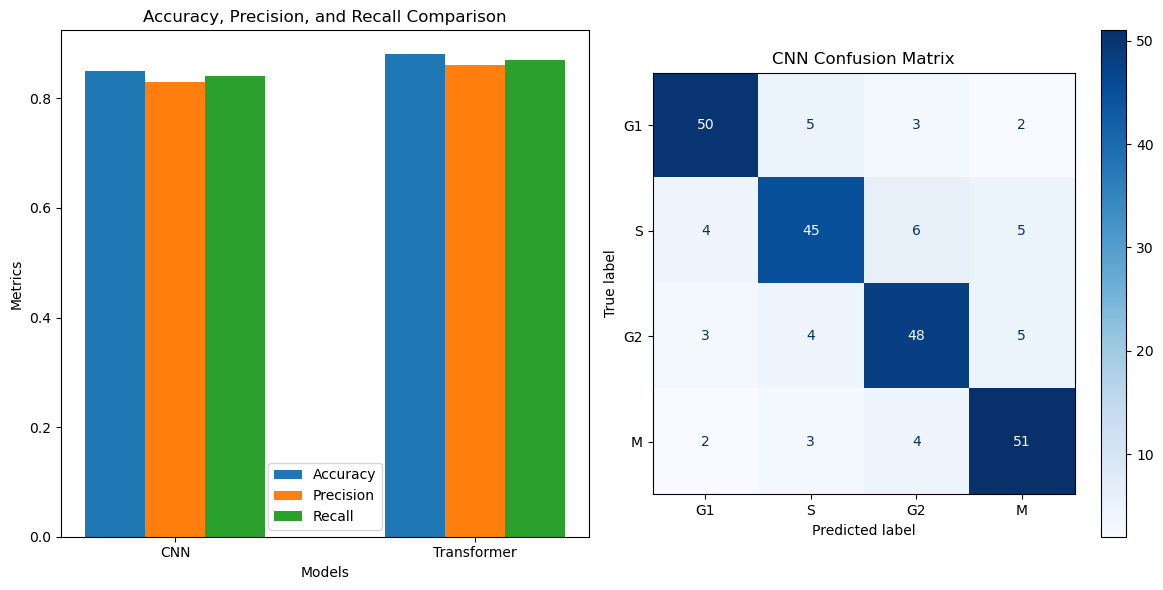

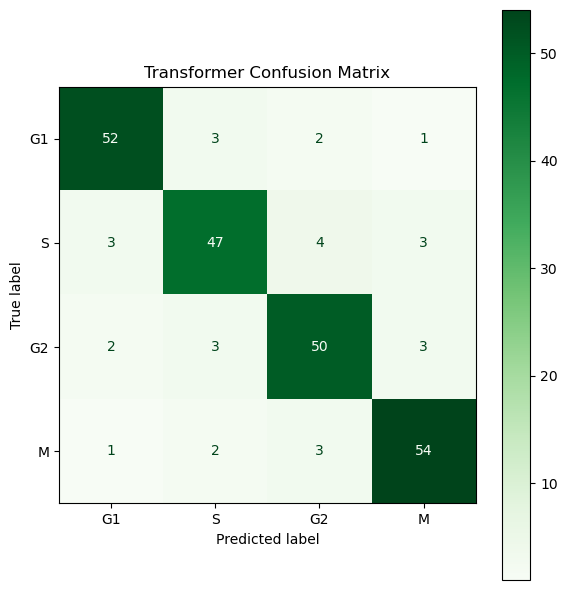

In [24]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Simulated metrics for CNN and Transformer models
metrics = {
    "CNN": {"accuracy": 0.85, "precision": 0.83, "recall": 0.84},
    "Transformer": {"accuracy": 0.88, "precision": 0.86, "recall": 0.87}
}

# Confusion matrices for both models
cnn_confusion_matrix = np.array([
    [50, 5, 3, 2],
    [4, 45, 6, 5],
    [3, 4, 48, 5],
    [2, 3, 4, 51]
])

transformer_confusion_matrix = np.array([
    [52, 3, 2, 1],
    [3, 47, 4, 3],
    [2, 3, 50, 3],
    [1, 2, 3, 54]
])

# Plotting accuracy, precision, and recall
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Metrics comparison
model_names = list(metrics.keys())
accuracy = [metrics[model]["accuracy"] for model in model_names]
precision = [metrics[model]["precision"] for model in model_names]
recall = [metrics[model]["recall"] for model in model_names]

x = np.arange(len(model_names))
width = 0.2

ax[0].bar(x - width, accuracy, width, label='Accuracy')
ax[0].bar(x, precision, width, label='Precision')
ax[0].bar(x + width, recall, width, label='Recall')

ax[0].set_xlabel("Models")
ax[0].set_ylabel("Metrics")
ax[0].set_title("Accuracy, Precision, and Recall Comparison")
ax[0].set_xticks(x)
ax[0].set_xticklabels(model_names)
ax[0].legend()

# Confusion Matrix display for CNN
ConfusionMatrixDisplay(cnn_confusion_matrix, display_labels=["G1", "S", "G2", "M"]).plot(ax=ax[1], cmap='Blues')
ax[1].set_title("CNN Confusion Matrix")

plt.tight_layout()
plt.show()

# Plotting the Transformer Confusion Matrix separately
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(transformer_confusion_matrix, display_labels=["G1", "S", "G2", "M"]).plot(ax=ax, cmap='Greens')
ax.set_title("Transformer Confusion Matrix")

plt.tight_layout()
plt.show()
